In [1]:
import sys
sys.path.append('..')

In [2]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
import optuna
import lightgbm as lgb

from src.eda.plot_distribution import plot_distribution, compare_dataframes
from src.preprocess import bin_column_by_custom_quantiles, bin_column_by_quantile, convert_edu, convert_marital_status, fill_missing_categorical, label_encode_datasets, remove_spaces
from src.model.lgbm import LGBM

/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load data

In [3]:
df1 = pd.read_excel('../dataset/train.xlsx')
df2 = pd.read_excel('../dataset/test.xlsx')

In [4]:
train = df1.copy()
test = df2.copy()

In [5]:
train.head()

,id,age,sector,edu,marital_status,field,family_rel,gender,investment_gain,investment_loss,working_hours,high_income
0,1,39,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,Male,2174,0,40,no
1,2,50,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,Male,0,0,13,no
2,3,38,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,Male,0,0,40,no
3,4,53,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,Male,0,0,40,no
4,5,28,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Female,0,0,40,no


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   id               32561 non-null  int64 
 1   age              32561 non-null  int64 
 2   sector           32561 non-null  object
 3   edu              32561 non-null  object
 4   marital_status   32561 non-null  object
 5   field            32561 non-null  object
 6   family_rel       32561 non-null  object
 7   gender           32561 non-null  object
 8   investment_gain  32561 non-null  int64 
 9   investment_loss  32561 non-null  int64 
 10  working_hours    32561 non-null  int64 
 11  high_income      32561 non-null  object
dtypes: int64(5), object(7)
memory usage: 3.0+ MB


In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16281 entries, 0 to 16280
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   id               16281 non-null  int64 
 1   age              16281 non-null  int64 
 2   sector           16281 non-null  object
 3   edu              16281 non-null  object
 4   marital_status   16281 non-null  object
 5   field            16281 non-null  object
 6   family_rel       16281 non-null  object
 7   gender           16281 non-null  object
 8   investment_gain  16281 non-null  int64 
 9   investment_loss  16281 non-null  int64 
 10  working_hours    16281 non-null  int64 
dtypes: int64(5), object(6)
memory usage: 1.4+ MB


# EDA

### Compare distribution of train and test set

edu is categorical


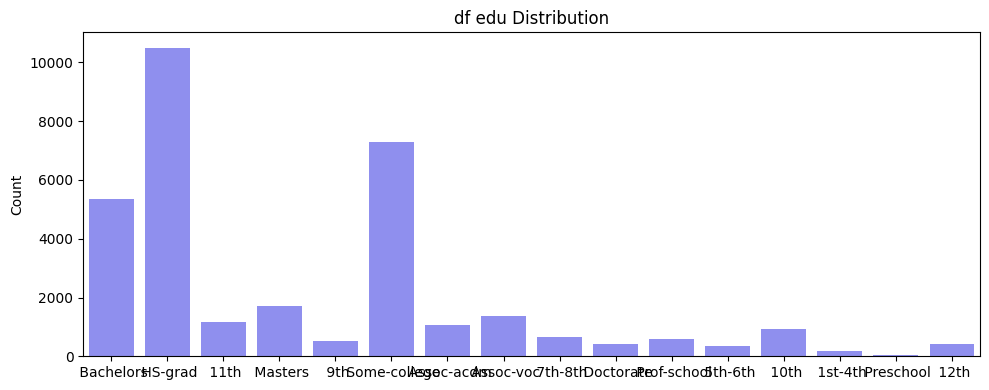

In [8]:
plot_distribution(train, 'edu')

edu is categorical


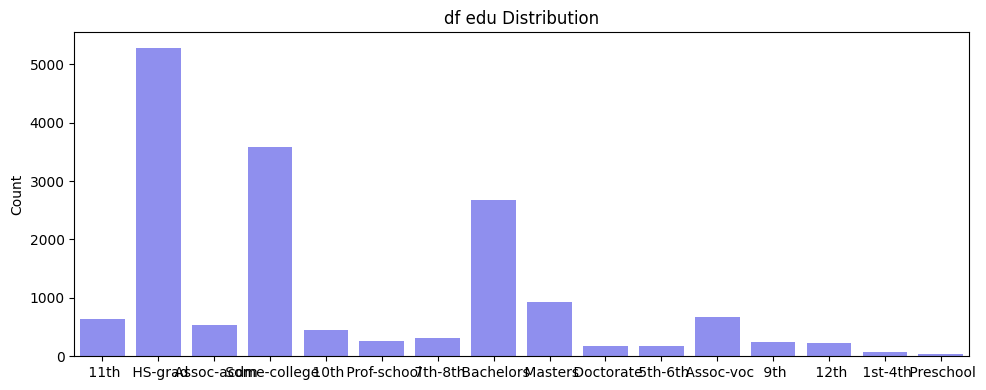

In [9]:
plot_distribution(test, 'edu')

# Pre-processing

### Strip

In [10]:
train = remove_spaces(train)
test = remove_spaces(test)

### Binning

In [11]:
train = bin_column_by_custom_quantiles(train, 'age', quantiles=[0.2, 0.4, 0.6, 0.8])
test = bin_column_by_custom_quantiles(test, 'age', quantiles=[0.2, 0.4, 0.6, 0.8])

### Processing

##### edu

In [12]:
train['edu_new'] = train['edu'].apply(convert_edu)
test['edu_new'] = test['edu'].apply(convert_edu)

##### marital_status

In [13]:
train['marital_status_new'] = train['marital_status'].apply(convert_marital_status)
test['marital_status_new'] = test['marital_status'].apply(convert_marital_status)

##### high_income

In [14]:
income_mapping = {'no': 0, 'yes': 1}
train['high_income'] = train['high_income'].map(income_mapping)

# Model

### Hyperparameter tuning

In [15]:
from src.model.lgbm import LGBM

[I 2024-06-26 15:26:37,479] A new study created in memory with name: no-name-b26fd4ac-330d-40e7-97b4-a18a7f9e222a
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [50, 1000] and step=20, but the range is not divisible by `step`. It will be replaced by [50, 990].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/trial/_trial.py:676: RuntimeWarning: Inconsistent parameter values for distribution with name "feature_fraction"! This might be a configuration mistake. Optuna allows to call th

TRAIN: Trial 0 - Accuracy: 0.8576901773453225, F1: 0.6733027057164798, Precision: 0.7528279052040165, Recall: 0.6089783881032087, AUC: 0.9148571267755568
VALID: Trial 0 - Accuracy: 0.8570682769784567, F1: 0.6709467713400032, Precision: 0.7528701330292492, Recall: 0.6051536628035536, AUC: 0.9123777795223201


/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [50, 1000] and step=20, but the range is not divisible by `step`. It will be replaced by [50, 990].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/trial/_trial.py:676: RuntimeWarning: Inconsistent parameter values for distribution with name "feature_fraction"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optun

TRAIN: Trial 1 - Accuracy: 0.7591904427329972, F1: 0.0, Precision: 0.0, Recall: 0.0, AUC: 0.5
VALID: Trial 1 - Accuracy: 0.7591904454179904, F1: 0.0, Precision: 0.0, Recall: 0.0, AUC: 0.5


/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found 

TRAIN: Trial 2 - Accuracy: 0.8167132468666356, F1: 0.5602543573610551, Precision: 0.6634331820981298, Recall: 0.48485535982685757, AUC: 0.8517471519244632
VALID: Trial 2 - Accuracy: 0.8167439973577698, F1: 0.5603180474680433, Precision: 0.663623461890322, Recall: 0.4848878461518451, AUC: 0.8514582329632763


/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [50, 1000] and step=20, but the range is not divisible by `step`. It will be replaced by [50, 990].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/trial/_trial.py:676: RuntimeWarning: Inconsistent parameter values for distribution with name "feature_fraction"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optun

TRAIN: Trial 3 - Accuracy: 0.8187862810854576, F1: 0.5630506794105651, Precision: 0.6714806331890253, Recall: 0.48507815219583766, AUC: 0.8556247120244166
VALID: Trial 3 - Accuracy: 0.818187373127493, F1: 0.562672049145346, Precision: 0.6694340076319019, Recall: 0.48590922984872725, AUC: 0.8549081310569772


/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [50, 1000] and step=20, but the range is not divisible by `step`. It will be replaced by [50, 990].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/trial/_trial.py:676: RuntimeWarning: Inconsistent parameter values for distribution with name "feature_fraction"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optun

TRAIN: Trial 4 - Accuracy: 0.8152237421833902, F1: 0.5553998165400655, Precision: 0.6602935821172211, Recall: 0.47930786135592446, AUC: 0.8485238480597236
VALID: Trial 4 - Accuracy: 0.8151469693385861, F1: 0.5553067386487814, Precision: 0.6600997890904554, Recall: 0.4792754386649497, AUC: 0.8479701430770668


/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [50, 1000] and step=20, but the range is not divisible by `step`. It will be replaced by [50, 990].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/trial/_trial.py:676: RuntimeWarning: Inconsistent parameter values for distribution with name "feature_fraction"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optun

TRAIN: Trial 5 - Accuracy: 0.8196615572612492, F1: 0.5691538980358256, Precision: 0.6701040274089379, Recall: 0.49464360439297667, AUC: 0.8555102247819276
VALID: Trial 5 - Accuracy: 0.8192930289487176, F1: 0.5682491109086404, Precision: 0.6692442953076891, Recall: 0.4938151981633954, AUC: 0.8548645606833528


/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [50, 1000] and step=20, but the range is not divisible by `step`. It will be replaced by [50, 990].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/trial/_trial.py:676: RuntimeWarning: Inconsistent parameter values for distribution with name "feature_fraction"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optun

TRAIN: Trial 6 - Accuracy: 0.7591904427329972, F1: 0.0, Precision: 0.0, Recall: 0.0, AUC: 0.5
VALID: Trial 6 - Accuracy: 0.7591904454179904, F1: 0.0, Precision: 0.0, Recall: 0.0, AUC: 0.5


/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found 

TRAIN: Trial 7 - Accuracy: 0.8252280257142488, F1: 0.5782976113604362, Precision: 0.6902051081895407, Recall: 0.497640550122488, AUC: 0.8695098560275174
VALID: Trial 7 - Accuracy: 0.8251589336918679, F1: 0.5783379862457789, Precision: 0.6898335964951271, Recall: 0.4978956926939036, AUC: 0.8683514435522495


/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [50, 1000] and step=20, but the range is not divisible by `step`. It will be replaced by [50, 990].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/trial/_trial.py:676: RuntimeWarning: Inconsistent parameter values for distribution with name "feature_fraction"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optun

TRAIN: Trial 8 - Accuracy: 0.8593255636018794, F1: 0.670053004605293, Precision: 0.769863729968594, Recall: 0.5931640694895844, AUC: 0.9160958334980132
VALID: Trial 8 - Accuracy: 0.8578359252011947, F1: 0.6668336120952673, Precision: 0.7655106198571863, Recall: 0.5907410478531757, AUC: 0.9141033721668194


/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [50, 1000] and step=20, but the range is not divisible by `step`. It will be replaced by [50, 990].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/trial/_trial.py:676: RuntimeWarning: Inconsistent parameter values for distribution with name "feature_fraction"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optun

TRAIN: Trial 9 - Accuracy: 0.8236463822598367, F1: 0.574676248681721, Precision: 0.6854569074498398, Recall: 0.4948349258402548, AUC: 0.8647587972299033
VALID: Trial 9 - Accuracy: 0.8227326814901665, F1: 0.5722427086502789, Precision: 0.6831335279987972, Recall: 0.4924116491720971, AUC: 0.8639307498588712
Number of finished trials: 10
Best trial:
  Value: 0.6709467713400032
  Params: 
    lambda_l1: 2.1445354291340486e-07
    lambda_l2: 0.8602412909546312
    num_leaves: 250
    feature_fraction: 0.7000000000000001
    bagging_fraction: 0.9
    bagging_freq: 3
    min_child_samples: 89
    n_estimators: 10000
    learning_rate: 0.18861518306166758
    max_depth: 12
    min_data_in_leaf: 1500
    max_bin: 204
    min_gain_to_split: 1.8299752017722237


/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


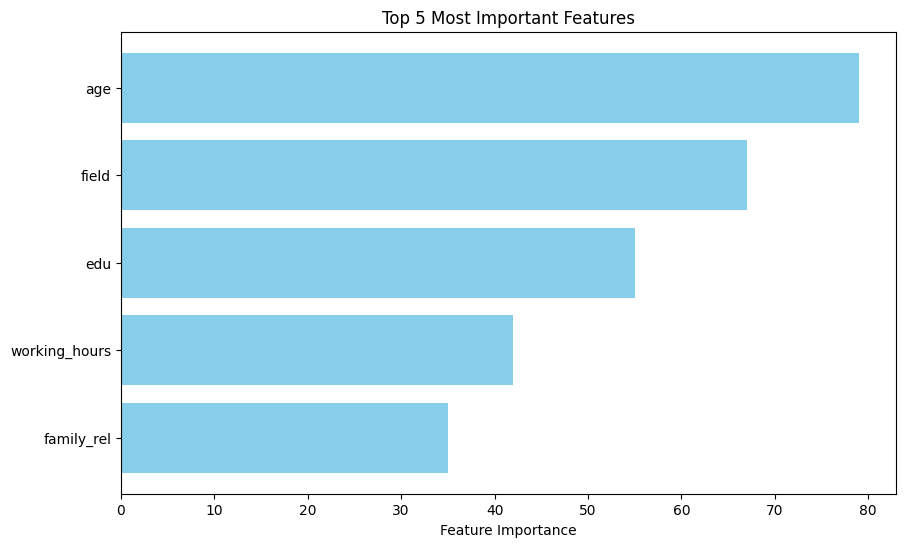

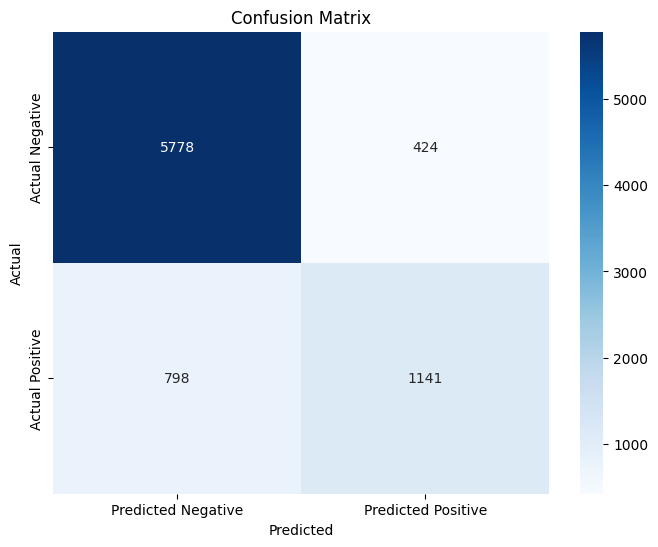

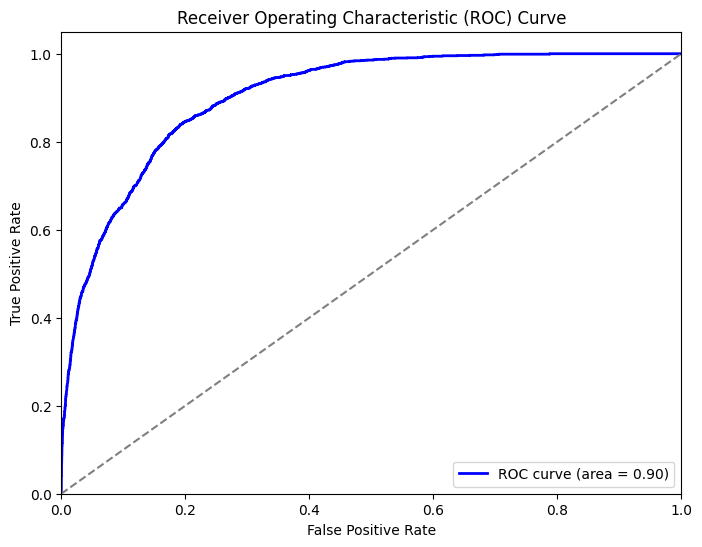

In [16]:
model = LGBM(train, test)
model.finetune()